In [1]:
from torchvision import datasets,transforms
import torch
import numpy as np



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2, fill=0),  # Padding with 2 pixels on each side with zero
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomAutocontrast(0.3),
    transforms.Normalize(.5,.5),
])


train_data = datasets.FashionMNIST("./dataset",train=True,download=True,transform=transform)
test_data = datasets.FashionMNIST("./dataset",train=False,download=True,transform=transform)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)


import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self,input_channels = 3,latent_space = 2) -> None:
        super().__init__()
        self.input_channels = input_channels
        self.latent_space = latent_space
     
        self.conv1 = nn.Conv2d(self.input_channels,32,3,2,2)
        self.batch_norm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,64,3,2,2)
        self.batch_norm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,128,3,2,2)
        self.batch_norm3 = nn.BatchNorm2d(128)

        self.flatten = nn.Flatten(1,-1)

        self.dense1 = nn.Linear(128*6*6,1024)
        self.act1 = nn.ReLU()

        self.dense2 = nn.Linear(1024,512)
        self.act2 = nn.ReLU()

        self.dense3 = nn.Linear(512,64)
        self.act3 = nn.ReLU()

        self.dense4_mu = nn.Linear(64, latent_space)
        self.dense4_logvar = nn.Linear(64, latent_space)

    def forward(self,x):
        x = self.batch_norm1(self.conv1(x))
        x = self.batch_norm2(self.conv2(x))
        x = self.batch_norm3(self.conv3(x))
    
        x = self.flatten(x)
        x = self.act1(self.dense1(x))
        x = self.act2(self.dense2(x))
        x = self.act3(self.dense3(x))
       

        return self.dense4_mu(x),self.dense4_logvar(x)


class Decoder(nn.Module):
    def __init__(self, latent_space,output_channel = 3) -> None:
        super().__init__()
        self.latent_space = latent_space
        self.output_channel = output_channel

        self.dense1 = nn.Linear(latent_space,64)
        self.act1 = nn.ReLU()

        self.dense2 = nn.Linear(64,512)
        self.act2 = nn.ReLU()

        self.dense3 = nn.Linear(512,1024)
        self.act3 = nn.ReLU()

        self.dense4 = nn.Linear(1024,128*6*6)
        self.act4 = nn.ReLU()

        self.unflat = nn.Unflatten(1, (128, 6, 6))

        self.deconv1 = nn.ConvTranspose2d(128,64,3,2,2,1)
        self.batch_norm1 = nn.BatchNorm2d(64)

        self.deconv2 = nn.ConvTranspose2d(64,32,3,2,2)
        self.batch_norm2 = nn.BatchNorm2d(32)

        self.deconv3 = nn.ConvTranspose2d(32,output_channel,3,2,2,1)
        self.batch_norm3 = nn.BatchNorm2d(output_channel)

    def forward(self,x):
        x = self.act1(self.dense1(x))
        x = self.act2(self.dense2(x))
        x = self.act3(self.dense3(x))
        x = self.act4(self.dense4(x))
        x = self.unflat(x)

        x = self.batch_norm1(self.deconv1(x))
        x = self.batch_norm2(self.deconv2(x))
        x = self.batch_norm3(self.deconv3(x))
        
        return torch.nn.functional.sigmoid(x)


class VAE(nn.Module):
    def __init__(self, input_channel,latent_space) -> None:
        super().__init__()

        self.inchannel = input_channel
        self.latent_space = latent_space
        self.encoder = Encoder(self.inchannel,self.latent_space)
        self.decoder = Decoder(self.latent_space,self.inchannel)

    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self,x):
        _mean,logvar = self.encoder(x)
        x = self.reparameterize(_mean,logvar)
        recon_x = self.decoder(x)
        return recon_x, _mean,logvar

        

In [2]:
model = VAE(1,2)

In [6]:
state_dict = torch.load("model_weights.pth",map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [60]:
min,max =np.array([-2.68054581, -2.5025897 ]), np.array([5.08031416, 4.39958668])
sample = np.random.uniform(min, max, size=(30, 2))
output = model.decoder(torch.Tensor(sample))

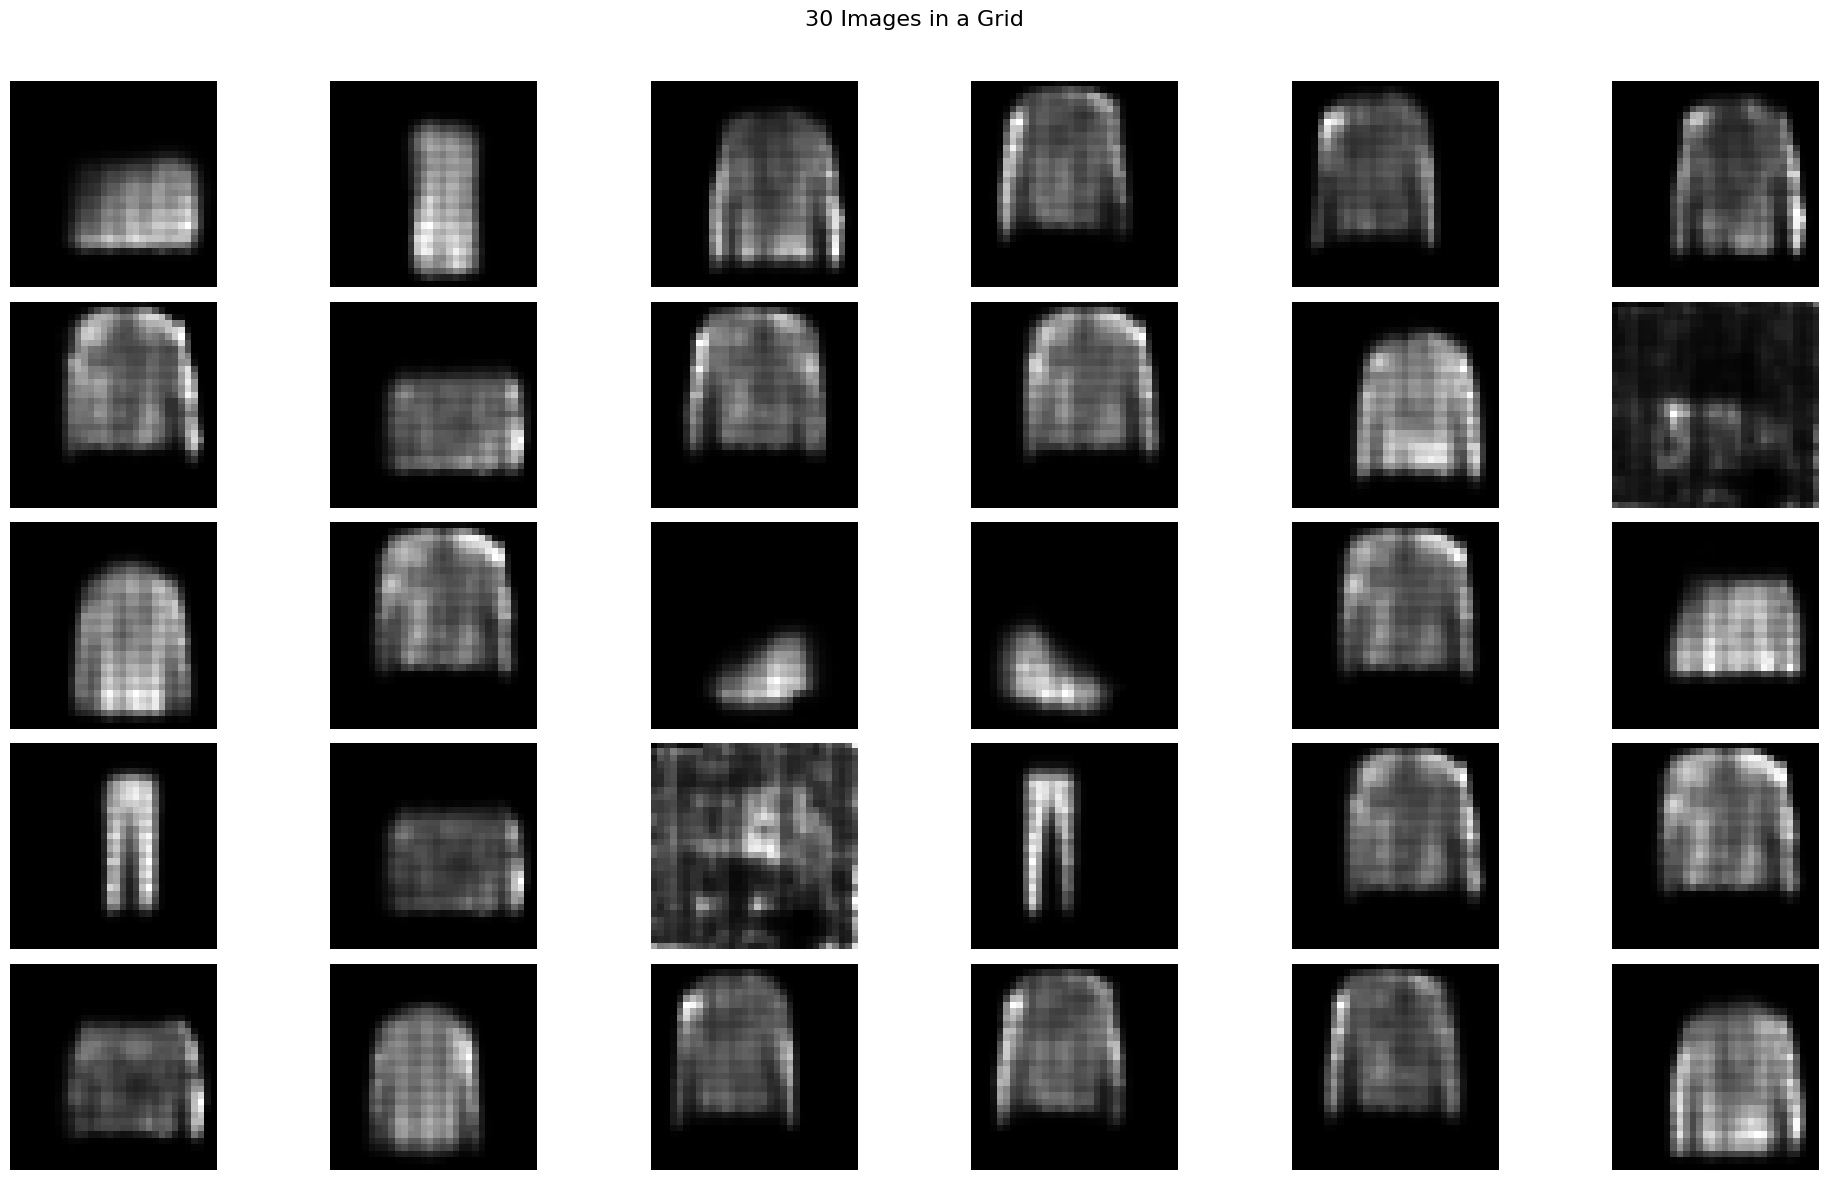

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of 18 random images for demonstration
# In practice, replace this with your actual image data
images = output  # Assuming images are 28x28

# Create a figure with a grid of subplots
fig, axes = plt.subplots(5, 6, figsize=(20, 12))  # 3 rows, 6 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the images and corresponding subplot axes
for i, (img, ax) in enumerate(zip(images, axes)):
    ax.imshow(img.permute(1,2,0).detach().numpy(), cmap='gray')
    ax.axis('off')  # Hide the axis

# Optionally, add a title to the figure
fig.suptitle(f'{len(images)} Images in a Grid', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Make room for the title

# Display the plot
plt.show()
